c:\Users\tangi\OneDrive\Documentos\UNT\TESIS II\DESARROLLO\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MÉTRICAS DE VALIDACIÓN DEL MODELO INVERSO (solo DE y LE)

1. MÉTRICAS GENERALES:
------------------------------
MSE - Train: 0.577442, Test: 0.460473
RMSE - Train: 0.759896, Test: 0.678582
MAE - Train: 0.600934, Test: 0.530102
R² promedio - Train: 0.4841, Test: 0.5327

2. MÉTRICAS POR VARIABLE DE SALIDA:
----------------------------------------

DE (mm/s):
  MSE - Train: 0.243193, Test: 0.143702
  MAE - Train: 0.448265, Test: 0.302372
  R² - Train: 0.1110, Test: 0.2437

LE (mm):
  MSE - Train: 0.911691, Test: 0.777245
  MAE - Train: 0.753604, Test: 0.757832
  R² - Train: 0.8573, Test: 0.8217

Promedio de residuos (Test):
DE (mm/s): Media = -0.003558, Std = 0.379064
LE (mm): Media = -0.483784, Std = 0.737020


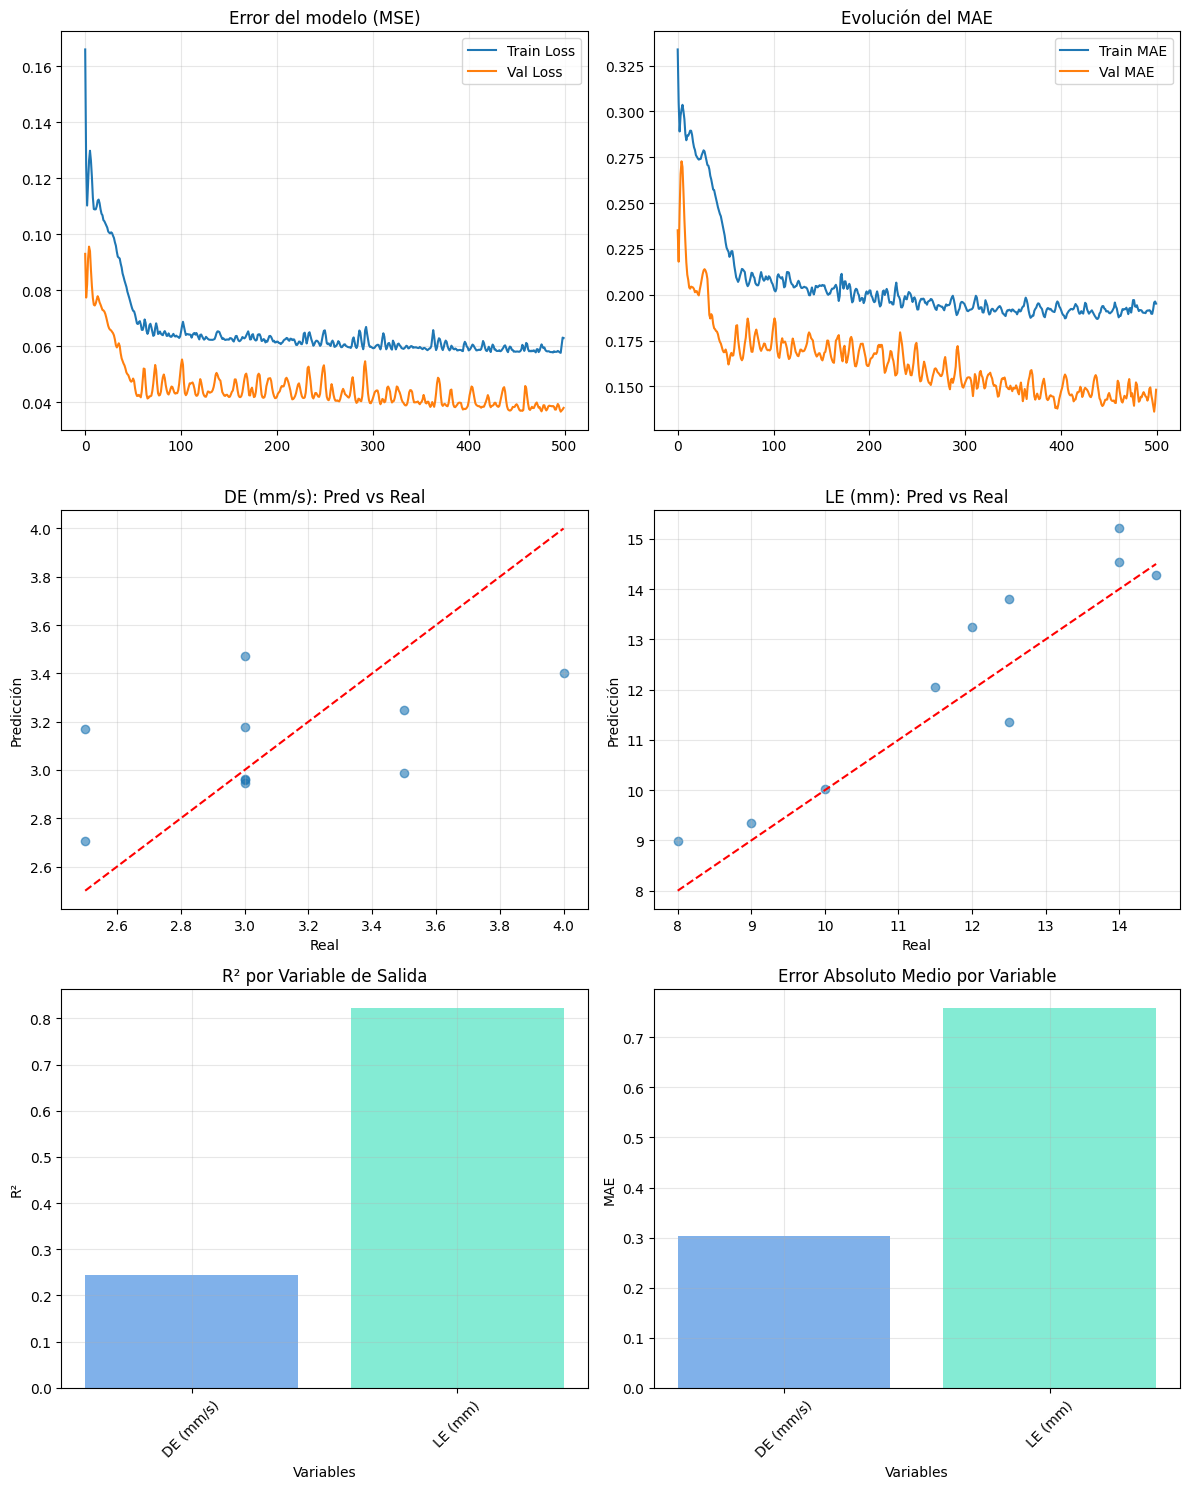


VALORES FINALES DE EVOLUCIÓN DEL MODELO (Epoch 500)
Loss final (Train - MSE): 0.062932
Loss final (Val - MSE):   0.038006
MAE final (Train):        0.195112
MAE final (Val):          0.148155

MÉTRICAS DE EVALUACIÓN — RNI (solo DE y LE)
R² DE (mm/s): 0.243675
R² LE (mm): 0.821733
MAE DE (mm/s): 0.302372
MAE LE (mm): 0.757832


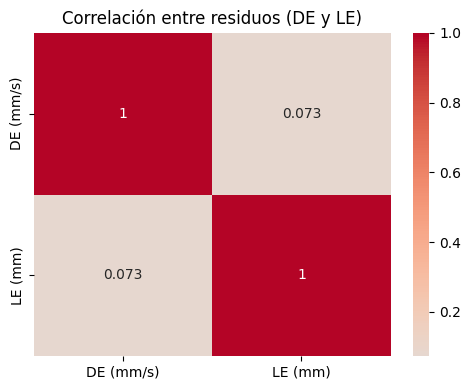

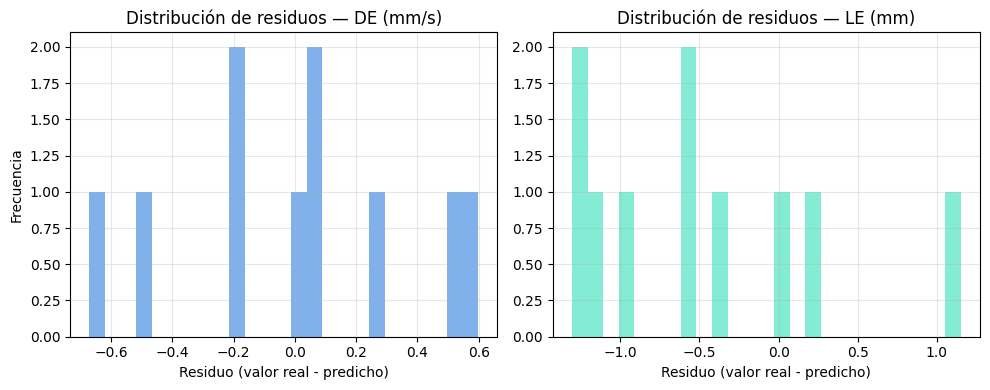

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow import keras

# === LEER LOS DATOS DESDE EXCEL ===
ruta_excel = 'datos2_clean.xlsx'
df = pd.read_excel(ruta_excel)

# Confirmamos que los nombres de columnas coincidan exactamente
df.columns = df.columns.str.strip()

# === INVERSO: ENTRADAS = [Longitud, Diametro] / SALIDAS = [DO, NO, UE, DE, LO, LE] ===
X_inv = df[["Longitud(mm)", "Diametro(mm)"]].values
y_fijas = df[["DO (mm/s)", "NO", "UE", "LO (mm)"]]   # Constantes
y_entrenar = df[["DE (mm/s)", "LE (mm)"]]           # Variables a predecir

# === ESCALAR DATOS ===
scaler_X_inv = MinMaxScaler()
X_inv_scaled = scaler_X_inv.fit_transform(X_inv)

scaler_y_entrenar = MinMaxScaler()
y_entrenar_scaled = scaler_y_entrenar.fit_transform(y_entrenar)

# === DIVIDIR DATOS ===
X_train, X_test, y_train, y_test = train_test_split(
    X_inv_scaled, y_entrenar_scaled, test_size=0.20, random_state=42)


# === MODELO INVERSO (solo DE y LE) ===
model_inv = Sequential([
    Dense(30, input_dim=2, activation='linear'),
    Dense(25, activation='tanh'),
    Dense(25, activation='sigmoid'),
    Dense(25, activation='sigmoid'),
    Dense(25, activation='tanh'),
    Dense(2, activation='linear')
])

# Compilar con métricas adicionales
model_inv.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # Mean Absolute Error
)


# === ENTRENAMIENTO ===
history_inv = model_inv.fit(
    X_train, y_train,
    epochs=500,
    verbose=0,
    validation_data=(X_test, y_test)
)

# === PREDICCIONES ===
y_train_pred = model_inv.predict(X_train, verbose=0)
y_test_pred = model_inv.predict(X_test, verbose=0)

# Convertir de vuelta a escala original
y_train_true_orig = scaler_y_entrenar.inverse_transform(y_train)
y_train_pred_orig = scaler_y_entrenar.inverse_transform(y_train_pred)
y_test_true_orig = scaler_y_entrenar.inverse_transform(y_test)
y_test_pred_orig = scaler_y_entrenar.inverse_transform(y_test_pred)

y_test_inv = scaler_y_entrenar.inverse_transform(y_test)
y_pred_test_inv = scaler_y_entrenar.inverse_transform(model_inv.predict(X_test, verbose=0))


# === Nombres de las salidas ===
output_names = ["DE (mm/s)", "LE (mm)"]


# === MÉTRICAS ===
def calculate_r2_multioutput(y_true, y_pred):
    #return [r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]
    r2_scores = []
    for i in range(y_true.shape[1]):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        r2_scores.append(r2)
    return r2_scores

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def calculate_normalized_rmse(y_true, y_pred):
    """Calcula RMSE normalizado"""
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (y_true.max() - y_true.min())

train_r2_scores = calculate_r2_multioutput(y_train_true_orig, y_train_pred_orig)
test_r2_scores = calculate_r2_multioutput(y_test_true_orig, y_test_pred_orig)

print("="*60)
print("MÉTRICAS DE VALIDACIÓN DEL MODELO INVERSO (solo DE y LE)")
print("="*60)

# === MÉTRICAS GENERALES ===
print("\n1. MÉTRICAS GENERALES:")
print("-" * 30)

# MSE
train_mse = np.mean((y_train_true_orig - y_train_pred_orig)**2)
test_mse = np.mean((y_test_true_orig - y_test_pred_orig)**2)
print(f"MSE - Train: {train_mse:.6f}, Test: {test_mse:.6f}")

# RMSE
train_rmse = calculate_rmse(y_train_true_orig, y_train_pred_orig)
test_rmse = calculate_rmse(y_test_true_orig, y_test_pred_orig)
print(f"RMSE - Train: {train_rmse:.6f}, Test: {test_rmse:.6f}")

# MAE
train_mae = mean_absolute_error(y_train_true_orig, y_train_pred_orig)
test_mae = mean_absolute_error(y_test_true_orig, y_test_pred_orig)
print(f"MAE - Train: {train_mae:.6f}, Test: {test_mae:.6f}")

# R² general (promedio)
print(f"R² promedio - Train: {np.mean(train_r2_scores):.4f}, Test: {np.mean(test_r2_scores):.4f}")

# === MÉTRICAS POR VARIABLE DE SALIDA ===
print("\n2. MÉTRICAS POR VARIABLE DE SALIDA:")
print("-" * 40)

for i, name in enumerate(output_names):
    print(f"\n{name}:")

    # MSE por variable
    var_train_mse = np.mean((y_train_true_orig[:, i] - y_train_pred_orig[:, i])**2)
    var_test_mse = np.mean((y_test_true_orig[:, i] - y_test_pred_orig[:, i])**2)

    # MAE por variable
    var_train_mae = mean_absolute_error(y_train_true_orig[:, i], y_train_pred_orig[:, i])
    var_test_mae = mean_absolute_error(y_test_true_orig[:, i], y_test_pred_orig[:, i])

    # R² por variable
    var_train_r2 = train_r2_scores[i]
    var_test_r2 = test_r2_scores[i]

    print(f"  MSE - Train: {var_train_mse:.6f}, Test: {var_test_mse:.6f}")
    print(f"  MAE - Train: {var_train_mae:.6f}, Test: {var_test_mae:.6f}")
    print(f"  R² - Train: {var_train_r2:.4f}, Test: {var_test_r2:.4f}")


# === RESIDUOS ===
residuals_test = y_test_true_orig - y_test_pred_orig
residuals_mean = np.mean(residuals_test, axis=0)
residuals_std = np.std(residuals_test, axis=0)

print("\nPromedio de residuos (Test):")
for i, name in enumerate(output_names):
    print(f"{name}: Media = {residuals_mean[i]:.6f}, Std = {residuals_std[i]:.6f}")

# === GRÁFICAS ===
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# 1. Curvas de pérdida
axes[0, 0].plot(history_inv.history['loss'], label='Train Loss')
axes[0, 0].plot(history_inv.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Error del modelo (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. MAE
axes[0, 1].plot(history_inv.history['mae'], label='Train MAE')
axes[0, 1].plot(history_inv.history['val_mae'], label='Val MAE')
axes[0, 1].set_title('Evolución del MAE')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Pred vs Real
for i, name in enumerate(output_names):
    axes[1, i].scatter(y_test_true_orig[:, i], y_test_pred_orig[:, i], alpha=0.6)
    axes[1, i].plot([y_test_true_orig[:, i].min(), y_test_true_orig[:, i].max()],
                    [y_test_true_orig[:, i].min(), y_test_true_orig[:, i].max()], 'r--')
    axes[1, i].set_title(f'{name}: Pred vs Real')
    axes[1, i].set_xlabel('Real')
    axes[1, i].set_ylabel('Predicción')
    axes[1, i].grid(alpha=0.3)


axes[2, 0].bar(range(len(output_names)), test_r2_scores, alpha=0.7, color=['#4a90e2', '#50e3c2'])
axes[2, 0].set_xlabel('Variables')
axes[2, 0].set_ylabel('R²')
axes[2, 0].set_title('R² por Variable de Salida')
axes[2, 0].set_xticks(range(len(output_names)))
axes[2, 0].set_xticklabels(output_names, rotation=45)
axes[2, 0].grid(alpha=0.3)

test_abs_errors = np.mean(np.abs(residuals_test), axis=0)
axes[2, 1].bar(range(len(output_names)), test_abs_errors, alpha=0.7, color=['#4a90e2', '#50e3c2'])
axes[2, 1].set_xlabel('Variables')
axes[2, 1].set_ylabel('MAE')
axes[2, 1].set_title('Error Absoluto Medio por Variable')
axes[2, 1].set_xticks(range(len(output_names)))
axes[2, 1].set_xticklabels(output_names, rotation=45)
axes[2, 1].grid(alpha=0.3)


plt.tight_layout()
plt.show()

# === VALORES FINALES DE LAS CURVAS DE ENTRENAMIENTO ===
# === CÁLCULO DE MÉTRICAS ===
mae_DE = mean_absolute_error(y_test_inv[:, 0], y_pred_test_inv[:, 0])
mae_LE = mean_absolute_error(y_test_inv[:, 1], y_pred_test_inv[:, 1])

r2_DE = r2_score(y_test_inv[:, 0], y_pred_test_inv[:, 0])
r2_LE = r2_score(y_test_inv[:, 1], y_pred_test_inv[:, 1])

residuos_DE = y_test_inv[:, 0] - y_pred_test_inv[:, 0]
residuos_LE = y_test_inv[:, 1] - y_pred_test_inv[:, 1]

final_loss = history_inv.history['loss'][-1]
final_val_loss = history_inv.history['val_loss'][-1]

final_mae = history_inv.history['mae'][-1]
final_val_mae = history_inv.history['val_mae'][-1]


print("\n" + "="*60)
print("VALORES FINALES DE EVOLUCIÓN DEL MODELO (Epoch 500)")
print("="*60)
print(f"Loss final (Train - MSE): {final_loss:.6f}")
print(f"Loss final (Val - MSE):   {final_val_loss:.6f}")
print(f"MAE final (Train):        {final_mae:.6f}")
print(f"MAE final (Val):          {final_val_mae:.6f}")
print("="*60)
# === IMPRESIÓN DE RESULTADOS NUMÉRICOS ===
print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN — RNI (solo DE y LE)")
print("="*60)
print(f"R² DE (mm/s): {r2_DE:.6f}")
print(f"R² LE (mm): {r2_LE:.6f}")
print(f"MAE DE (mm/s): {mae_DE:.6f}")
print(f"MAE LE (mm): {mae_LE:.6f}")
print("="*60)



# === MATRIZ DE CORRELACIÓN DE ERRORES ===
plt.figure(figsize=(5, 4))
correlation_matrix = np.corrcoef(residuals_test.T)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            xticklabels=output_names, yticklabels=output_names, center=0)
plt.title('Correlación entre residuos (DE y LE)')
plt.tight_layout()
plt.show()



# === GRÁFICA 1: R² por variable ===
#plt.figure(figsize=(6,4))
#plt.bar(["DE (mm/s)", "LE (mm)"], [r2_DE, r2_LE], color=['#4a90e2', '#50e3c2'])
#plt.ylim(0, 1)
#plt.title("Coeficiente de determinación R² por variable de salida")
#plt.ylabel("R²")
#plt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.show()

# === GRÁFICA 2: Distribución de residuos ===
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(residuos_DE, bins=25, color='#4a90e2', alpha=0.7)
plt.title("Distribución de residuos — DE (mm/s)")
plt.xlabel("Residuo (valor real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.hist(residuos_LE, bins=25, color='#50e3c2', alpha=0.7)
plt.title("Distribución de residuos — LE (mm)")
plt.xlabel("Residuo (valor real - predicho)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === GRÁFICA 3: Error Absoluto Medio (MAE) por variable ===
#plt.figure(figsize=(6,4))
#plt.bar(["DE (mm/s)", "LE (mm)"], [mae_DE, mae_LE], color=['#4a90e2', '#50e3c2'])
#plt.title("Error Absoluto Medio (MAE) por variable")
#plt.ylabel("MAE")
#lt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.show()




In [2]:
# === EJEMPLO DE PREDICCIÓN FINAL ===
long_diam_deseado = np.array([[17.298, 0.263]])  # Longitud, Diametro
long_diam_scaled = scaler_X_inv.transform(long_diam_deseado)
valores_fijos = y_fijas.mean().values  # DO, NO, UE, LO
pred_scaled = model_inv.predict(long_diam_scaled, verbose=0)
pred = scaler_y_entrenar.inverse_transform(pred_scaled)

# Construir salida completa: [DO, NO, UE, DE, LO, LE]
ejemplo_completo = np.concatenate([
    valores_fijos[0:3], pred[0, 0:1], valores_fijos[3:4], pred[0, 1:2]
])

output_names_full = ["DO (mm/s)", "NO", "UE", "DE (mm/s)", "LO (mm)", "LE (mm)"]

print("\n" + "="*60)
print("EJEMPLO DE PREDICCIÓN (con valores fijos)")
print("="*60)
print(f"Entrada: Longitud={long_diam_deseado[0][0]:.3f}mm, Diámetro={long_diam_deseado[0][1]:.3f}mm")
print("Parámetros estimados:")
for name, val in zip(output_names_full, ejemplo_completo):
    print(f"  {name}: {val:.6f}")





EJEMPLO DE PREDICCIÓN (con valores fijos)
Entrada: Longitud=17.298mm, Diámetro=0.263mm
Parámetros estimados:
  DO (mm/s): 6.500000
  NO: 8.000000
  UE: 2.000000
  DE (mm/s): 3.140863
  LO (mm): 15.000000
  LE (mm): 7.039961


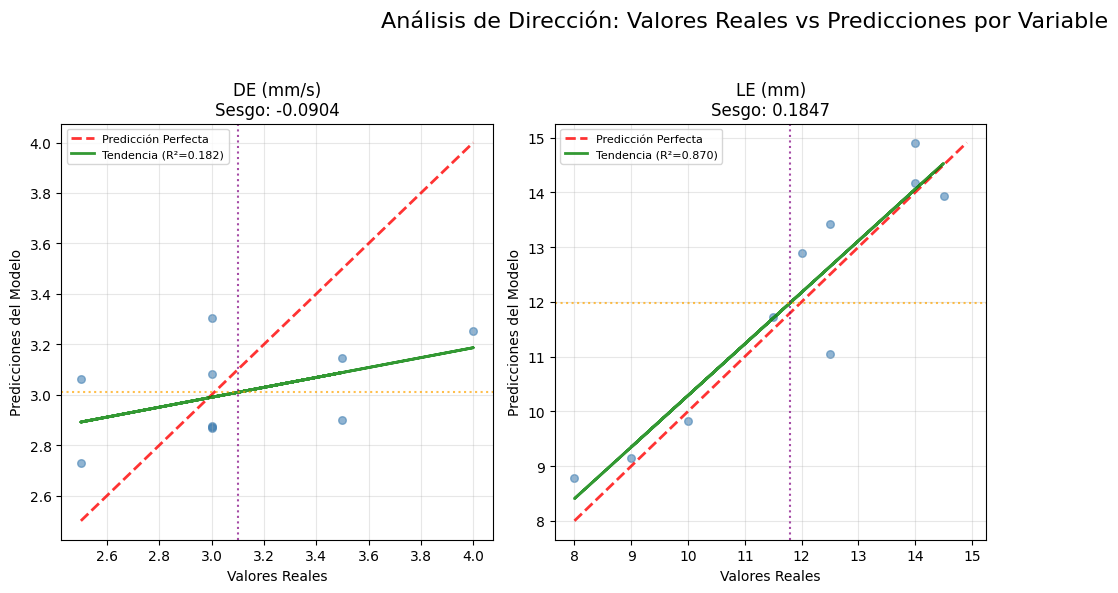

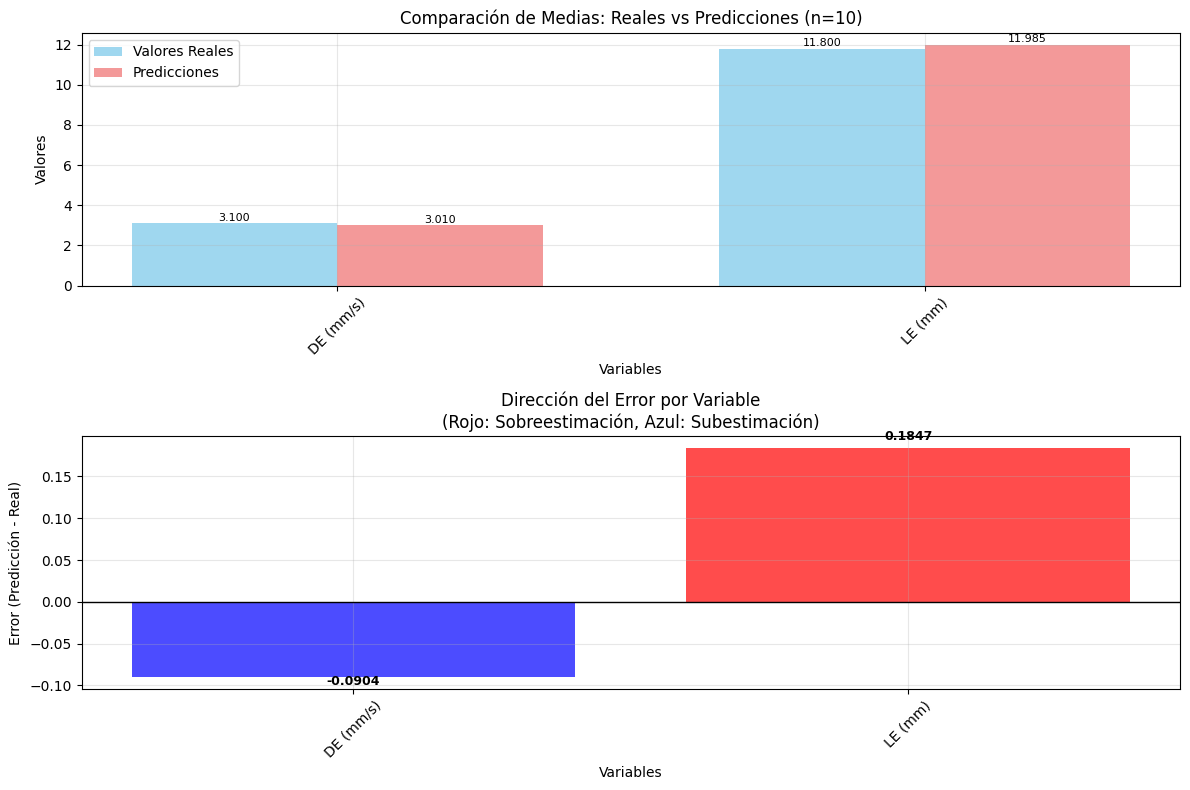


ANÁLISIS DE DIRECCIÓN Y MAGNITUD DE ERRORES

DE (mm/s):
  Sesgo promedio: -0.090369
  Error absoluto: 0.325633
  Tendencia: SUBESTIMA
  Rango real: [2.5000, 4.0000]
  Rango predicho: [2.7295, 3.3045]

LE (mm):
  Sesgo promedio: 0.184670
  Error absoluto: 0.624561
  Tendencia: SOBREESTIMA
  Rango real: [8.0000, 14.5000]
  Rango predicho: [8.7832, 14.9085]


In [3]:

# === GRÁFICA ADICIONAL: DIRECCIÓN Y MAGNITUD DE ERRORES ===
plt.figure(figsize=(15, 10))

# Crear subplots para cada variable de salida
for i, name in enumerate(output_names):
    plt.subplot(2, 3, i+1)

    # Valores reales vs predicciones para esta variable específica
    real_values = y_test_true_orig[:, i]
    pred_values = y_test_pred_orig[:, i]

    # Crear scatter plot
    plt.scatter(real_values, pred_values, alpha=0.6, s=30, color='steelblue')

    # Línea de predicción perfecta (y = x)
    min_val = min(real_values.min(), pred_values.min())
    max_val = max(real_values.max(), pred_values.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Predicción Perfecta')

    # Línea de tendencia (regresión lineal)
    z = np.polyfit(real_values, pred_values, 1)
    p = np.poly1d(z)
    plt.plot(real_values, p(real_values), 'g-', linewidth=2, alpha=0.8, label=f'Tendencia (R²={test_r2_scores[i]:.3f})')

    # Calcular estadísticas para esta variable
    bias = np.mean(pred_values - real_values)  # Sesgo promedio

    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones del Modelo')
    plt.title(f'{name}\nSesgo: {bias:.4f}')
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)

    # Añadir líneas para mostrar el sesgo
    if abs(bias) > 0.001:  # Solo si el sesgo es significativo
        plt.axhline(y=np.mean(pred_values), color='orange', linestyle=':', alpha=0.7, label=f'Media Pred')
        plt.axvline(x=np.mean(real_values), color='purple', linestyle=':', alpha=0.7, label=f'Media Real')

plt.suptitle('Análisis de Dirección: Valores Reales vs Predicciones por Variable', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# === GRÁFICA DE VECTORES DE ERROR (MAGNITUD Y DIRECCIÓN) ===
plt.figure(figsize=(12, 8))

# Seleccionar las primeras 20 muestras para mejor visualización
n_samples = min(20, len(y_test_true_orig))
indices = np.arange(n_samples)

# Crear gráfica de barras comparativas
x_pos = np.arange(len(output_names))
width = 0.35

# Promedios para cada variable
real_means = np.mean(y_test_true_orig[:n_samples], axis=0)
pred_means = np.mean(y_test_pred_orig[:n_samples], axis=0)

plt.subplot(2, 1, 1)
bars1 = plt.bar(x_pos - width/2, real_means, width, label='Valores Reales', alpha=0.8, color='skyblue')
bars2 = plt.bar(x_pos + width/2, pred_means, width, label='Predicciones', alpha=0.8, color='lightcoral')

# Añadir valores encima de las barras
for i, (real, pred) in enumerate(zip(real_means, pred_means)):
    plt.text(i - width/2, real + max(real_means)*0.01, f'{real:.3f}', ha='center', fontsize=8)
    plt.text(i + width/2, pred + max(pred_means)*0.01, f'{pred:.3f}', ha='center', fontsize=8)

plt.xlabel('Variables')
plt.ylabel('Valores')
plt.title(f'Comparación de Medias: Reales vs Predicciones (n={n_samples})')
plt.xticks(x_pos, output_names, rotation=45)
plt.legend()
plt.grid(alpha=0.3)

# Gráfica de errores direccionales
plt.subplot(2, 1, 2)
errors = pred_means - real_means
colors = ['red' if err > 0 else 'blue' for err in errors]

bars = plt.bar(x_pos, errors, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Añadir valores de error
for i, err in enumerate(errors):
    plt.text(i, err + max(abs(errors))*0.05*np.sign(err), f'{err:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.xlabel('Variables')
plt.ylabel('Error (Predicción - Real)')
plt.title('Dirección del Error por Variable\n(Rojo: Sobreestimación, Azul: Subestimación)')
plt.xticks(x_pos, output_names, rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === ANÁLISIS DE PATRONES DE ERROR ===
print("\n" + "="*60)
print("ANÁLISIS DE DIRECCIÓN Y MAGNITUD DE ERRORES")
print("="*60)

for i, name in enumerate(output_names):
    real_vals = y_test_true_orig[:, i]
    pred_vals = y_test_pred_orig[:, i]

    bias = np.mean(pred_vals - real_vals)
    abs_bias = np.mean(np.abs(pred_vals - real_vals))

    # Determinar tendencia
    if bias > abs_bias * 0.1:
        trend = "SOBREESTIMA"
    elif bias < -abs_bias * 0.1:
        trend = "SUBESTIMA"
    else:
        trend = "BALANCEADO"

    print(f"\n{name}:")
    print(f"  Sesgo promedio: {bias:.6f}")
    print(f"  Error absoluto: {abs_bias:.6f}")
    print(f"  Tendencia: {trend}")
    print(f"  Rango real: [{real_vals.min():.4f}, {real_vals.max():.4f}]")
    print(f"  Rango predicho: [{pred_vals.min():.4f}, {pred_vals.max():.4f}]")

In [4]:
# Guarda el modelo completo: arquitectura + pesos + compilación

keras.models.save_model(model_inv, 'inverse_nn_fijo.keras')

# === GUARDAR ESCALADORES ===
joblib.dump(scaler_X_inv, 'scaler_X_inv_fijo.pkl')
joblib.dump(scaler_y_entrenar, 'scaler_y_inv_fijo.pkl')

print("✅ Modelo y escaladores guardados correctamente:")
print(" - inverse_nn_fijo.keras")
print(" - scaler_X_inv_fijo.pkl")
print(" - scaler_y_inv_fijo.pkl")

#from google.colab import drive
#drive.mount('/content/drive')
#model_inv.save('/content/drive/MyDrive/modelo_inverso.h5')


✅ Modelo y escaladores guardados correctamente:
 - inverse_nn_fijo.keras
 - scaler_X_inv_fijo.pkl
 - scaler_y_inv_fijo.pkl
